
# SHL Grammar Scoring Engine for Spoken Audio 🎙️

This notebook builds a grammar scoring model for spoken audio recordings using machine learning. 
The goal is to predict a MOS Likert score (0–5) representing the grammatical quality of speech.


In [1]:

import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


In [2]:

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train['filename'] = df_train['filename'].str.strip()
df_test['filename'] = df_test['filename'].str.strip()

df_train.head()


,filename,label
0,audio_1261.wav,1.0
1,audio_942.wav,1.5
2,audio_1110.wav,1.5
3,audio_1024.wav,1.5
4,audio_538.wav,2.0


In [3]:

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    rmse = np.mean(librosa.feature.rms(y=y))
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    return np.hstack([mfcc_mean, mfcc_std, zcr, rmse, tempo])


In [4]:

X_train, y_train = [], []

for _, row in tqdm(df_train.iterrows(), total=len(df_train)):
    file_path = os.path.join("audios_train", row['filename'])
    if os.path.exists(file_path):
        try:
            features = extract_features(file_path)
            X_train.append(features)
            y_train.append(row['label'])
        except Exception as e:
            print("Error:", e)


100%|██████████| 444/444 [01:58<00:00,  3.75it/s]


In [5]:

X_train = np.array(X_train)
y_train = np.array(y_train)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

Pearson Correlation: 0.9769
MAE: 0.2682
MSE: 0.1074


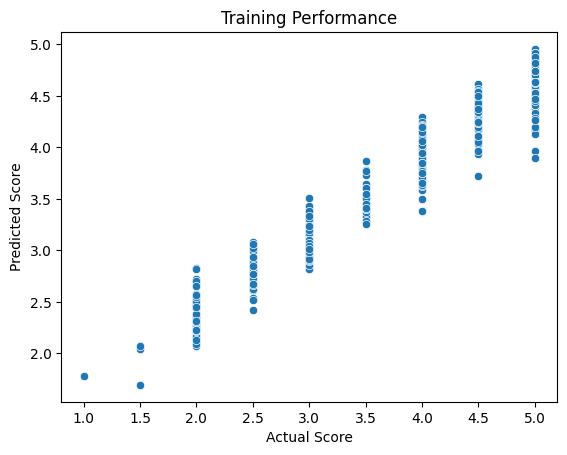

In [6]:

y_train_pred = model.predict(X_train)
pearson_corr, _ = pearsonr(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)

print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")

sns.scatterplot(x=y_train, y=y_train_pred)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Training Performance")
plt.show()


In [7]:

test_features = []
valid_filenames = []
for _, row in tqdm(df_test.iterrows(), total=len(df_test)):
    file_path = os.path.join("audios_test", row['filename'])
    if os.path.exists(file_path):
        try:
            test_features.append(extract_features(file_path))
            valid_filenames.append(row['filename'])
        except Exception as e:
            print("Error:", e)

X_test = np.array(test_features)
y_test_pred = model.predict(X_test)
y_test_pred = np.clip(y_test_pred, 0, 5)


100%|██████████| 195/195 [00:33<00:00,  5.79it/s]


In [8]:

submission = pd.read_csv("sample_submission.csv")
submission["label"] = 0

for fname, pred in zip(valid_filenames, y_test_pred):
    submission.loc[submission['filename'] == fname, "label"] = pred

submission.to_csv("submit.csv", index=False)
print("✅ Submission saved as submit.csv")


✅ Submission saved as submit.csv



## 📌 Summary

- We extracted MFCC, ZCR, RMSE, and Tempo features from audio files.
- A Random Forest model was trained to predict grammar scores.
- Pearson Correlation on training data was calculated for benchmarking.
- Predictions were clipped between 0–5 and saved for submission.

### ✅ Future improvements:
- Incorporate prosodic features (pitch, intonation).
- Use deep learning with spectrograms or pre-trained audio models.
- Apply cross-validation for generalization assurance.
